# Homework 2: ``pandas``, ``matplotlib``, and ``sklearn``
**Created by:**&emsp;**Jacob Norman**  
**Date:**&emsp;&emsp;&emsp;&nbsp;&nbsp;&nbsp;&nbsp;**2/24/2019**
## Overview
This homework assignment covers the remaining content from Jake Vanderplas' text *Python Data Science Handbook*. This includes ``pandas``, ``matplotlib`` (and ``seaborn``), and ``sklearn``. I decided to group these three chapters together because they are so tightly linked anyway. Group by analysis with ``pandas`` is often supplemented with plotting in ``matplotlib`` or ``seaborn``. This is often known as *exploratory data analysis*, or EDA. The first part of this assignment will involve some EDA on a baseball dataset. Afterwords, I will use this analysis as a basis for a machine learning model with ``sklearn``.
## About the Data
The data used for this assignment is pitch-by-pitch data for Justin Verlander for the entire 2017 MLB season, including the postseason. Perhaps 2011, when he won the AL MVP, AL Cy Young, and AL pitching Triple Crown (W, ERA, Strikeouts), would have been a better year to analyze; however, the data was not as complete in this year. You may remember 2017 as the year the Detroit Tigers traded JV to the Houston Astros. In return the Tigers got some solid prospects, Jake Rogers (C), Daz Cameron (OF), and Franklin Perez (RHP). JV's hefty contract was a principal factor in the deal, hence why he was traded after the waiver-free deadline. To seal the deal, the Tigers had to pay \$8 million of JV's contract in 2018 and 2019. However, having that contract off the Tiger's payroll has freed them up and allowed them to accelerate their rebuild. The deal worked out for JV, as he finally became a World Series Champion. He was a key component in the Astro's pitching rotation, arguably being the reason they won the World Series. 

PITCHf/x is a relatively new tool used for Sabermetrics. Starting in 2006, PITCHf/x has recorded pitch-level data for individual players. The earlier years of the application are not as complete, with many missing values or even entire columns. ``pybaseball`` is a way to extract PITCHf/x and other baseballdata directly into Python. You can read about the functions of the package [here](https://www.pydoc.io/pypi/pybaseball-1.0.1/). There are many R packages, such as ``baseballr``, ``Lahman``, and ``pitchRx`` that do a better job, but, as this is a Python class, I opted for the slightly less robust ``pybaseball``. 

Here is a way to install the package, if you wish:

In [9]:
# !pip install pybaseball

We begin with the standard imports:

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(style = 'whitegrid')
import pybaseball

If you ever wondered why ``seaborn`` is commonly imported as ``sns`` and not something more intuitive such as ``sb`` or ``sbn`` it is because it refers to Rob Lowe's character Samuel Norman Seaborn on the political drama *The West Wing*. It is apparently a joke. You may have already knew this, but I found it interesting.  

> Source: [Reddit](https://www.reddit.com/r/learnpython/comments/5oscmr/why_is_seaborn_commonly_imported_as_sns/) and [StackOverflow](https://stackoverflow.com/questions/41499857/seaborn-why-import-as-sns).

In [11]:
player_id = pybaseball.playerid_lookup('Verlander', first = 'Justin')
jv_id = player_id['key_mlbam'][0]
jv = pybaseball.statcast_pitcher(start_dt = '2017-04-02', end_dt = '2017-11-01', player_id = jv_id)
jv.head(10)

Gathering player lookup table. This may take a moment.
Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,FF,2017-10-31,97.4,-1.9446,6.7237,Justin Verlander,641355,434378,strikeout,swinging_strike,...,2,1,2,1,1,2,2,1,Standard,Standard
1,FF,2017-10-31,97.1,-1.8633,6.7674,Justin Verlander,641355,434378,NaN,foul,...,2,1,2,1,1,2,2,1,Standard,Standard
2,FF,2017-10-31,96.1,-1.8595,6.8649,Justin Verlander,641355,434378,NaN,swinging_strike,...,2,1,2,1,1,2,2,1,Standard,Standard
3,FF,2017-10-31,96.6,-1.8450,6.8482,Justin Verlander,641355,434378,NaN,ball,...,2,1,2,1,1,2,2,1,Standard,Standard
4,FC,2017-10-31,91.5,-2.2148,6.5903,Justin Verlander,457759,434378,field_out,hit_into_play,...,2,1,2,1,1,2,2,1,Strategic,Standard
5,FC,2017-10-31,91.9,-2.1884,6.5650,Justin Verlander,457759,434378,NaN,foul,...,2,1,2,1,1,2,2,1,Strategic,Standard
6,FC,2017-10-31,91.8,-2.3221,6.5049,Justin Verlander,457759,434378,NaN,foul_tip,...,2,1,2,1,1,2,2,1,Strategic,Standard
7,FC,2017-10-31,90.7,-2.2522,6.7167,Justin Verlander,457759,434378,NaN,foul,...,2,1,2,1,1,2,2,1,Strategic,Standard
8,SL,2017-10-31,87.5,-2.3266,6.4741,Justin Verlander,608369,434378,sac_fly,hit_into_play_score,...,1,1,1,1,1,1,1,1,Strategic,Standard
9,FF,2017-10-31,97.1,-1.9415,6.6737,Justin Verlander,608369,434378,NaN,foul,...,1,1,1,1,1,1,1,1,Strategic,Standard


Here is a sample of the data. It is clearly loaded with (90!) variables to analyze. Perhaps it is better to view the overall structure of the dataframe.

In [12]:
jv.game_date = pd.to_datetime(jv.game_date)
jv.zone = jv.zone.astype('object')
jv = jv.dropna(axis = 'columns', how = 'all')
jv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4065 entries, 0 to 4064
Data columns (total 82 columns):
pitch_type                         4065 non-null object
game_date                          4065 non-null datetime64[ns]
release_speed                      4065 non-null float64
release_pos_x                      4065 non-null float64
release_pos_z                      4065 non-null float64
player_name                        4065 non-null object
batter                             4065 non-null int64
pitcher                            4065 non-null int64
events                             983 non-null object
description                        4065 non-null object
zone                               4065 non-null object
des                                983 non-null object
game_type                          4065 non-null object
stand                              4065 non-null object
p_throws                           4065 non-null object
home_team                          4065 non-nu

Clearly the previous view of the dataframe did not do it justice. These are all of the variables available for all  4065 pitches JV threw in 2017. Exracting this data directly from [Baseball Savant](https://baseballsavant.mlb.com/statcast_search) or [Brook's Baseball](http://www.brooksbaseball.net/pfxVB/pfx.php?) would be a very tedious task, but ``pybaseball`` makes the process very quick and painless. There are some columns that contain all NaN values; however, it appears that this is because they were deprecated and are captured in a different variable. [Here](http://www.johnedwardsstats.com/2018/05/the-complete-idiots-guide-to-playing.html) is an in-depth description of what each variable represents.  
## EDA with ``pandas``, ``matplotlib``, and ``seaborn``  
The principal function of ``pandas`` is the group by analysis, similiar to ``dplyr`` in R. This allows for interesting views of the data that can lead to conclusions that cannot be drawn from simply looking at the individual observations. A possible group by would be by ``game_date``, essentially giving the stats for each of JV's starts or pitching appearances. For this assignment, I will be plotting using the ``seaborn`` API. This is mainly because we did not cover this topic in PCDA and I prefer the cleaner, more modern plots created from ``seaborn``.  

Let's do a group by ``game_date``:

In [13]:
jv.groupby(['game_date']).mean().head(10)

,release_speed,release_pos_x,release_pos_z,batter,pitcher,hit_location,balls,strikes,game_year,pfx_x,...,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score
game_date,,,,,,,,,,,,,,,,,,,,,
2017-04-04,90.933010,-2.520919,6.281090,551432.524272,434378.0,4.833333,0.776699,0.990291,2017.0,-1.068738,...,32.242718,2.912621,1.368932,4.825243,1.368932,4.825243,4.825243,1.368932,1.368932,4.825243
2017-04-10,89.208929,-2.489267,6.363852,524848.892857,434378.0,5.875000,0.955357,0.955357,2017.0,-0.304473,...,23.732143,3.151786,0.187500,0.758929,0.758929,0.187500,0.758929,0.187500,0.758929,0.187500
2017-04-15,91.604706,-2.410621,6.344404,526465.352941,434378.0,5.850000,0.858824,0.800000,2017.0,-0.654444,...,23.011765,2.858824,4.364706,1.152941,4.364706,1.152941,1.152941,4.364706,4.364706,1.152941
2017-04-21,91.063551,-2.452093,6.519348,553271.308411,434378.0,5.764706,1.121495,1.056075,2017.0,-0.666577,...,26.962617,3.317757,0.000000,1.476636,0.000000,1.476636,1.476636,0.000000,0.000000,1.476636
2017-04-27,91.637815,-2.489193,6.286086,512402.848739,434378.0,5.560000,0.865546,1.126050,2017.0,-0.442470,...,25.033613,3.361345,0.117647,0.142857,0.142857,0.117647,0.142857,0.117647,0.142857,0.117647
2017-05-02,91.275424,-2.431496,6.285583,527200.906780,434378.0,5.640000,1.042373,0.762712,2017.0,-0.581047,...,29.627119,2.906780,3.093220,0.991525,0.991525,3.093220,0.991525,3.093220,0.991525,3.093220
2017-05-09,91.434259,-2.337607,6.309935,542967.935185,434378.0,5.583333,0.944444,0.851852,2017.0,-0.842523,...,27.685185,2.870370,1.324074,2.564815,1.324074,2.564815,2.564815,1.324074,1.324074,2.564815
2017-05-14,91.477358,-2.422964,6.366220,513454.500000,434378.0,4.809524,0.735849,0.924528,2017.0,-0.997809,...,27.537736,2.764151,1.301887,1.000000,1.301887,1.000000,1.000000,1.301887,1.301887,1.000000
2017-05-20,91.731193,-2.407803,6.318866,535007.293578,434378.0,4.875000,0.844037,0.880734,2017.0,-0.655028,...,31.550459,2.889908,6.220183,1.376147,1.376147,6.220183,1.376147,6.220183,1.376147,6.220183


It's hard to discern a lot from this look. Most of the variables do not have a meaningful interpretation when they are grouped by the mean. Perhaps one of the few ones of note is average ``release_speed``. Let's see what games JV threw the hardest on average.

In [14]:
jv.iloc[:,:3].groupby(['game_date']).mean().sort_values(by = 'release_speed', ascending = False).head(10)

,release_speed
game_date,
2017-10-31,93.721505
2017-10-25,92.858228
2017-08-20,92.682143
2017-10-05,92.243434
2017-08-25,92.212500
2017-09-05,92.129126
2017-10-09,92.107500
2017-07-08,91.928696
2017-07-19,91.773832


His 2 hardest throwing games were both in the World Series. It seems JV is very "clutch". Additionally, it is typical for pitchers, especially those over the age of 34, to throw slower as the season progresses. They get burned out or injured, or the long 162 game season just wears them down. In JV's case, he actually threw all of his hardest games after the All-Star break. In fact, more than half of his top 10 hardest throwing games were in the final 2 months of the season. This is very impressive, especially given the fact that many analysts, especially those in Detroit, considered him on the border of being washed up. Boy were they wrong. 

Let's looks at JV's strike zone for the entire 2017 season.

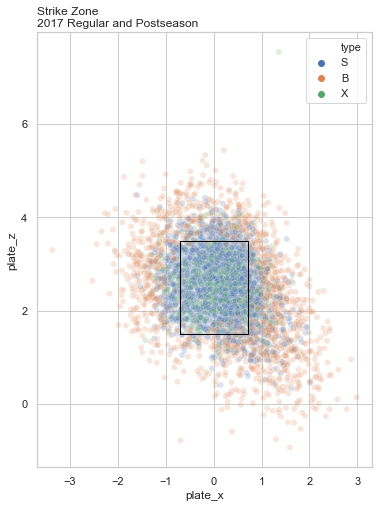

In [15]:
plt.figure(figsize=(6, 8))
sns.scatterplot(x = 'plate_x', y = 'plate_z', hue = 'type', 
                data = jv, alpha = 0.2).add_patch(patches.Rectangle((-0.71,1.5),1.42,2, fill = False, edgecolor = 'black'))
plt.title('Strike Zone\n2017 Regular and Postseason', loc = 'left');

This is pretty messy. Even with the transparency, it is hard to see the strike zone. I researched the shape of the strike zone and it seems it is generally defined as the rectangle created by the point (-0.71, 1.5) with a width of 1.42 and a height of 2. The blue points are strikes, while the orange points are balls. The green points are designated "X", which is anything that is not a ball or strike, but is usually a ball in play. The reason that they are XZ coordinates and not XY is because this is a view of where the ball crosses the Y-plane, the batter's box.

This is a great example of when Jake VanderPlas said that often times ``matplotlib`` is needed to augment ``seaborn`` to create the desired plot, especially if it is somewhat complex.

Let's try this same look except just for the postseason only.

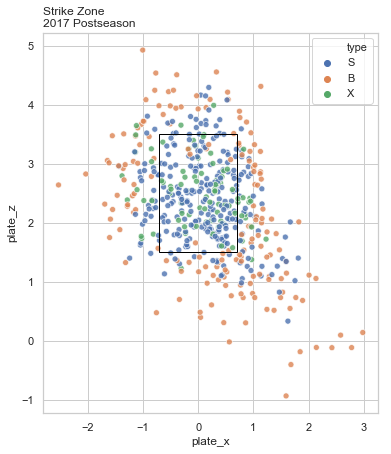

In [16]:
plt.figure(figsize=(6, 7))
sns.scatterplot(x = 'plate_x', y = 'plate_z', hue = 'type', 
                data = jv[(jv['game_type'] == 'L') | (jv['game_type'] == 'W') | (jv['game_type'] == 'D')], 
                alpha = 0.8).add_patch(patches.Rectangle((-0.71,1.5),1.42,2, fill = False, edgecolor = 'black'))
plt.title('Strike Zone\n2017 Postseason', loc = 'left');

This is more readible. The strike zone seems somewhat more obvious, although the human element of balls vs strikes is clearly still present (hence, why there should be an electronic strike zone!).  

Let's look at the relationship between pitch location and pitch type.

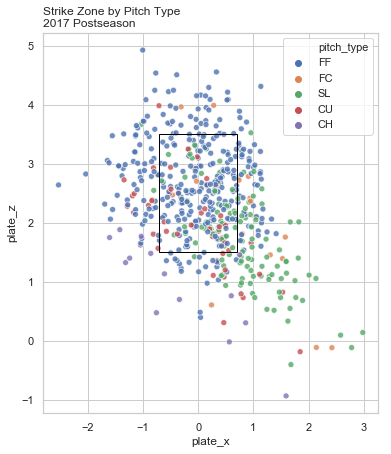

In [17]:
plt.figure(figsize=(6, 7))
sns.scatterplot(x = 'plate_x', y = 'plate_z', hue = 'pitch_type', 
                data = jv[(jv['game_type'] == 'L') | (jv['game_type'] == 'W') | (jv['game_type'] == 'D')], 
                alpha = 0.8).add_patch(patches.Rectangle((-0.71,1.5),1.42,2, fill = False, edgecolor = 'black'))
plt.title('Strike Zone by Pitch Type\n2017 Postseason', loc = 'left');

It appears JV likes to throw his slider (SL) low and away to RH batters and low and in on LH batters. His curveballs (CU) are all over the place, but they too are lower in the strike zone. Here is a zone chart for the strike zone:

![title](zones.png).  

Basic knowledge of baseball asserts that "hanging" breaking balls are often hammered for extra bases or home runs. Hanging breaking balls would be in the middle of the strike zone and above. Let's test this assumpton using group by analysis.

In [18]:
breaking = jv.groupby(['pitch_type', 'zone']).sum()
breaking.sort_values('iso_value', ascending = False).iso_value.head(15)

pitch_type  zone
SL          2       17.0
            6       12.0
FF          5       12.0
SL          5       11.0
FF          6       10.0
            4        9.0
            2        8.0
SL          3        7.0
CU          5        6.0
            8        4.0
CH          8        4.0
SL          9        4.0
CU          7        3.0
FF          1        3.0
CU          2        3.0
Name: iso_value, dtype: float64

``iso_value`` is the number of extra bases a player recorded on a hit. Therefore, high values indicate many extra bases given up. It is no surprise that the pitch that results in the most extra bases given up for JV is a slider in zone 2. That is the top of the strike zone, making the pitch a hanging breaking ball. Sliders in zones 5 and 6 (the middle of the strike zone) are also high ``iso_value``s. Additionally, curveballs in the middle of the strike zone have led to extra base hits. JV has superior control because, based on the previous plot, he tends to keep his breaking balls low.

Now let's analyze the spin rate for his pitches, measured in RPM.

In [19]:
jv.groupby(['pitch_type']).mean().release_spin_rate.sort_values(ascending = False)

pitch_type
CU    2808.531046
FT    2551.500000
FF    2551.461409
SL    2550.694508
FC    2528.516129
CH    1818.418750
Name: release_spin_rate, dtype: float64

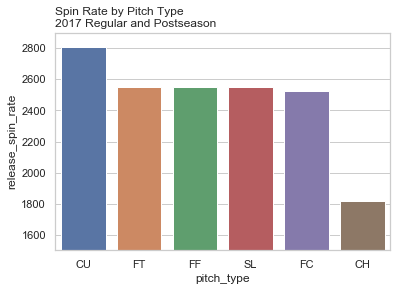

In [20]:
sns.barplot(x = jv.groupby(['pitch_type']).mean().release_spin_rate.sort_values(ascending = False).index, 
            y = 'release_spin_rate',
            data = jv.groupby(['pitch_type']).mean().sort_values(by = ['release_spin_rate'], ascending = False))
plt.title('Spin Rate by Pitch Type\n2017 Regular and Postseason', loc = 'left')
plt.ylim(1500, 2900);

JV has a nasty 12-6 curveball, so it is no surprise that it has by far the highest spin rate. His four-seamer, two-seamer, slider and cutter all have roughly the same spin rate. His changeup features an extreme drop in average spin rate, presumably to create a more erratic and unpredictable path of flight from the batter's perspective.  

Now, let's see how often he throws each pitch.

In [123]:
jv.pivot_table(index = 'pitch_type', values = 'batter', aggfunc = len).sort_values(by = 'batter', ascending = False)

,batter
pitch_type,
FF,2371
SL,876
CU,614
CH,161
FC,31
FT,12


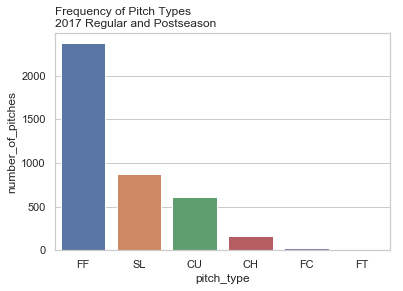

In [126]:
sns.barplot(x = jv.pivot_table(index = 'pitch_type', values = 'batter', aggfunc = len).sort_values(by = 'batter', ascending = False).index, 
            y = 'batter',
            data = jv.pivot_table(index = 'pitch_type', values = 'batter', aggfunc = len).sort_values(by = 'batter', ascending = False))
plt.title('Frequency of Pitch Types\n2017 Regular and Postseason', loc = 'left')
plt.ylabel('number_of_pitches');

He throws his four seamer (FF) over 50% of the time.  

Now let's move into analyzing something JV is well known for: his strikeouts. First, we have to create a strikeout column. Let's iterate over the ``events`` variable and create a binary ``strikeout`` column.

In [21]:
strikeout = []
for k in range(0, len(jv.events)):
    if jv.events[k] == 'strikeout':
        strikeout.append(1)
    else:
        strikeout.append(0)

In [22]:
jv['strikeout'] = strikeout

In [23]:
jv.groupby(['pitch_type']).sum().strikeout.sort_values(ascending = False)

pitch_type
FF    118
SL     86
CU     43
CH      8
FC      1
FT      0
Name: strikeout, dtype: int64

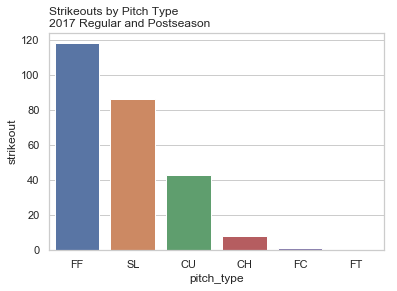

In [24]:
sns.barplot(x = jv.groupby(['pitch_type']).sum().strikeout.sort_values(ascending = False).index, 
            y = 'strikeout',
            data = jv.groupby(['pitch_type']).sum().sort_values(by = 'strikeout', ascending = False))
plt.title('Strikeouts by Pitch Type\n2017 Regular and Postseason', loc = 'left');

It is clear that JV's put-away pitch is his four-seamer by far. He also goes to his slider quite often.  

Let's plot his strike zone on his strikeout pitches.

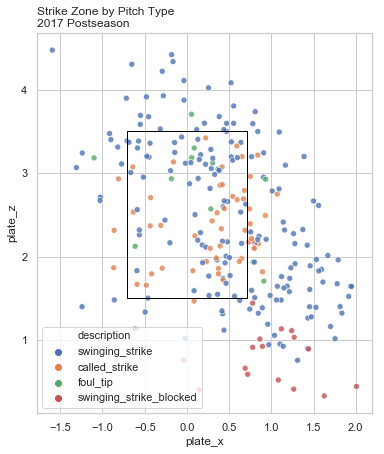

In [25]:
plt.figure(figsize=(6, 7))
sns.scatterplot(x = 'plate_x', y = 'plate_z', hue = 'description', 
                data = jv[jv['strikeout'] == 1], 
                alpha = 0.8).add_patch(patches.Rectangle((-0.71,1.5),1.42,2, fill = False, edgecolor = 'black'))
plt.title('Strike Zone by Pitch Type\n2017 Postseason', loc = 'left');

What's better: a called strikeout or a swinging strikeout? That is a subjective question, but it is clear that most of his strikeouts are swinging strikeouts. The green points indicate foul tips, which is odd, aren't we plotting strikeouts? Given the extremely low number of foul tips, these are foul tips into the catcher's mitt and thus, a strikeout.  

But we do not need to guess, let's check the data!

In [26]:
jv[(jv['strikeout'] == 1) & (jv['description'] == 'foul_tip')].des

53              Rich Hill strikes out on a foul tip.  
619          Rougned Odor strikes out on a foul tip.  
1363    Curtis Granderson strikes out on a foul tip.  
2034         Lorenzo Cain strikes out on a foul tip.  
2050       Josh Donaldson strikes out on a foul tip.  
2395      Jorge Bonifacio strikes out on a foul tip.  
3226         Kole Calhoun strikes out on a foul tip.  
3229        Luis Valbuena strikes out on a foul tip.  
3611         Jarrod Dyson strikes out on a foul tip.  
3652        Taylor Motter strikes out on a foul tip.  
4035       Avisail Garcia strikes out on a foul tip.  
Name: des, dtype: object

Indeed, our assumptions are proved correct! Let's move on to other views of JV's strikeouts.

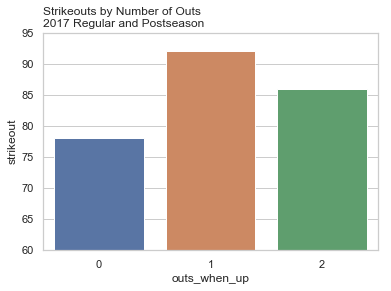

In [27]:
sns.barplot(x = jv.groupby(['outs_when_up']).sum().strikeout.index, 
            y = 'strikeout',
            data = jv.groupby(['outs_when_up']).sum())
plt.title('Strikeouts by Number of Outs\n2017 Regular and Postseason', loc = 'left')
plt.ylim(60, 95);

It seems that JV is more likely to record a strikeout when there is 1 or 2 outs already. This is likely a result of pitch strategy. For example, if there are runners at the corners with 1 out, a strikeout stops the runs from scoring; however, a deep fly ball will likely result in the runner on third scoring.  

## Machine Learning with ``sklearn``

For the remainder of this assignment, we will attempt to create a classification model to determine the ``pitch_type`` for any given pitch. This is quite similar to my final project last year, which attempted to classify Kobe Bryant's shots throughout his entire career as either makes or misses, although last year my project was done exclusively in R using numerous packages. For this part of my homework, I will exclusively use Python and the ``sklearn`` package. Whats great about this package is that I do not have to change much for each model, the blueprint is the same:
1. Choose a class of model
2. Choose model hyperparameters
3. Arrange data into a features matrix and target vector
4. Fit the model to data  

After that, it is simply making predictions and assessing the accuracy of said predictions.

First of all, let's do all of the data preprocessing and create the train-test split.

In [28]:
# removes any columns with NaN values
jv_model = jv.dropna(axis = 'columns')

# removes the target vector and columns directly related to it
jv_model = jv_model.drop('pitch_type', axis = 'columns')
jv_model = jv_model.drop('game_date', axis = 'columns')
jv_model = jv_model.drop('description', axis = 'columns')
jv_model = jv_model.drop('pitch_name', axis = 'columns')

# encodes object variables to integers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for i in jv_model.columns:
    if jv_model[i].dtype == object:
        jv_model[i] = le.fit_transform(jv_model[i])
    else:
        pass

# creates the features matrix and target vector
x = jv_model
y = jv['pitch_type']
    
# train-test split
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state = 0,
                                  test_size = 0.5)

### Random Forest

Let's start with a **random forest** model. From my previous assignment I know that it is one of the best classifiers, and the best of the tree methods.  

In [29]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=0)
model_rf.fit(xtrain,ytrain)
ypred = model_rf.predict(xtest)

In [30]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

          CH       0.98      0.98      0.98        86
          CU       1.00      1.00      1.00       310
          FC       0.40      1.00      0.57         8
          FF       1.00      0.99      1.00      1187
          FT       0.00      0.00      0.00         0
          SL       0.99      0.97      0.98       442

   micro avg       0.99      0.99      0.99      2033
   macro avg       0.73      0.82      0.75      2033
weighted avg       0.99      0.99      0.99      2033



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


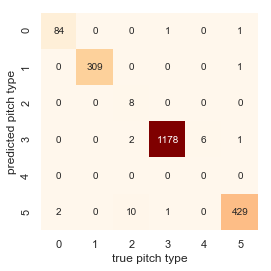

In [31]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap ='OrRd')
plt.xlabel('true pitch type')
plt.ylabel('predicted pitch type');

In [32]:
print('Accuracy:\t',metrics.accuracy_score(ytest, ypred))

Accuracy:	 0.9877029021151008


Honestly, this looks too good to be true. I believe I have removed all of the columns of the data that are directly tied to ``pitch_type``, such as ``pitch_name``. I suppose it is possible that all of the data supplied is so descriptive that it is incredibly accurate in regards to classifying pitches. I do know that Statcast does not ask each pitcher what type of pitch they threw for every pitch, rather, they use their own classification model to determine pitch type.

### Gaussian Naive Bayes

I probably should have started with **Gaussian Naive Bayes** as a baseline for model performance. It will be interesting to see how it stacks up against the random forest model.

In [33]:
from sklearn.naive_bayes import GaussianNB
model_gnb = GaussianNB()
model_gnb.fit(xtrain, ytrain)
ypred_gnb = model_gnb.predict(xtest)

In [34]:
yprob = model_gnb.predict_proba(xtest)
pd.DataFrame(yprob.round(5), ).head(10)

,0,1,2,3,4,5
0,0.00000,0.00000,0.00000,0.00000,1.0,0.00000
1,0.00000,0.00000,0.00000,1.00000,0.0,0.00000
2,0.00000,0.00000,0.00000,0.00000,1.0,0.00000
3,0.99997,0.00000,0.00000,0.00000,0.0,0.00003
4,0.00000,0.00000,0.00000,0.00000,0.0,1.00000
5,0.00117,0.00006,0.00000,0.00000,0.0,0.99877
6,0.00000,1.00000,0.00000,0.00000,0.0,0.00000
7,0.00000,1.00000,0.00000,0.00000,0.0,0.00000
8,0.00000,1.00000,0.00000,0.00000,0.0,0.00000
9,0.19350,0.00000,0.80629,0.00005,0.0,0.00016


This is a dataframe stating the probabilities what each pitch is classified as. It can show where certain pitches start to blend together in the eyes of the model.

In [35]:
print(metrics.classification_report(ypred_gnb, ytest))

              precision    recall  f1-score   support

          CH       0.43      0.97      0.60        38
          CU       0.99      0.99      0.99       309
          FC       0.60      0.10      0.16       126
          FF       0.64      0.99      0.78       761
          FT       0.83      0.01      0.02       447
          SL       0.77      0.95      0.85       352

   micro avg       0.71      0.71      0.71      2033
   macro avg       0.71      0.67      0.57      2033
weighted avg       0.75      0.71      0.61      2033



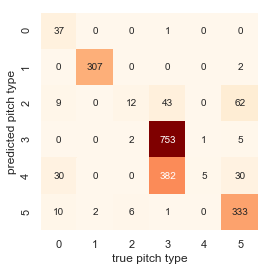

In [36]:
mat_gnb = confusion_matrix(ytest, ypred_gnb)
sns.heatmap(mat_gnb.T, square=True, annot=True, fmt='d', cbar=False, cmap ='OrRd')
plt.xlabel('true pitch type')
plt.ylabel('predicted pitch type');

In [37]:
print('Accuracy:\t',metrics.accuracy_score(ytest, ypred_gnb))

Accuracy:	 0.7117560255779636


The accuracy is much lower for this model. Like Jake VanderPlas states, it is a quick and dirty method to get a baseline estimate. This suggests the random forest model is a huge improvement over a "naive" model.

### Principle Component Analysis

**Principle component analysis** (PCA) is a method of dimensionality reduction. This is great for my data set, which originally contained 90 columns, or features.

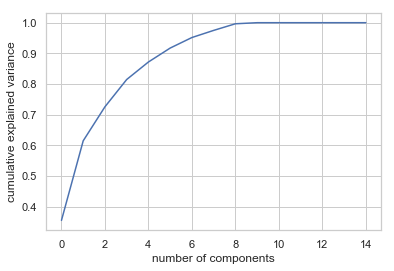

In [114]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 15)
pca.fit(x)
plt.plot(np.cumsum(pca.fit(x).explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

What we see here is that reducing the dimensionality to 8 components explains 100% of the variance of all the original features. However, 2 principle components explains roughly 70% of the variance of the data, so let's try 2 first.

In [39]:
pca = PCA(n_components = 2)
pca.fit(x)
projected = pca.fit_transform(x)
print(x.shape)
print(projected.shape)

(4065, 55)
(4065, 2)


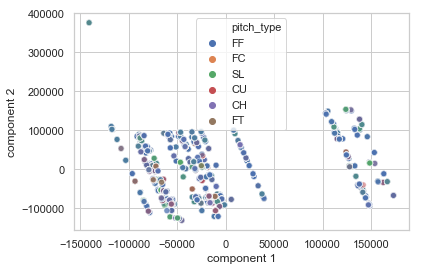

In [40]:
sns.scatterplot(projected[:, 0], projected[:, 1], hue = y, alpha = 0.5)
plt.xlabel('component 1')
plt.ylabel('component 2');

The above plot suggests that 2 principle components is not enough to accurately classify the pitches. Getting closer to 8 components would be better.  

In [61]:
pca_full = PCA(n_components = 8)
pca_full.fit(x)
projected_full = pca_full.fit_transform(x)

Now let's take this and apply it to the next type of model.

### Gaussian Mixture Models

A **Gaussian mixture model** (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. Unlike k-means, GMMs are more flexible. Since this is an unsupervised learning method, let's use the entire data set.

In [63]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=6)
gmm.fit(projected_full)
ypred_gmm = gmm.predict(projected_full)

In [75]:
probs = gmm.predict_proba(projected_full)
pd.DataFrame(probs.round(5)).head(10)

,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0


Once again, this is a dataframe of the probabilities of what each pitch is classified as. So far, 4 is the only classification. I'm willing to bet that this is the FF, or four seamer, because we already determined he throws it over half the time.

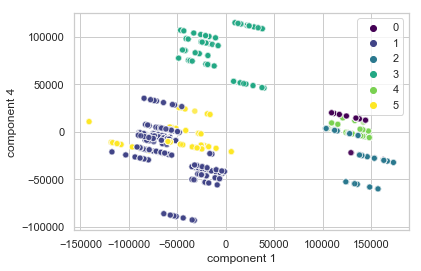

In [106]:
sns.scatterplot(projected_full[:, 0], projected_full[:, 3],
                hue = ypred_gmm, alpha = 0.5, legend = 'full', palette = 'viridis')
plt.xlabel('component 1')
plt.ylabel('component 4');

The groups are not easily discernable from the above plot, but it is clear that it is better than the PCA with only 2 components.  

Now we run into a problem. We have six groups, labeled 0-5, but what pitches are they? Beyond the fact that 4 corresponds to "FF", it is difficult to tell without making a false assumption about one of the pitch types. Therefore, it is impossible to compute an error-free accuracy score. This is not a huge deal; this was more an exercise in dimensionality reduction. After all, the random forest model is suspiciously accurate.  

## Conclusions

As far as the exploratory data analysis goes, this was a very fun data set to work on. Going into this assignment, I wasn't sure I was going to be able to create the strike zone plots, but I proved myself wrong. There's nothing like combining good Googling with intuition to create something with analytical value. Originally, I wanted to analyze a NFL or NBA data set, but there was just nothing that compared to this PITCHf/x data. In fact, the NFL data is so basic I did not even know what I could do with it, especially when it came to modeling. So sorry for the MLB data set overload; that said, it was nice to research Justin Verlander's statistics. I was able to confirm some things I knew just from watching him pitch, such as his put-away pitch being his four-seamer. I feel like I actually created some analysis of value, rather than just cranking out plots and group by analyses just to finish the assignment. It wasn't as simple or nice as using ``dplyr`` or ``ggplot2`` in R, but using ``seaborn`` helped a bit.  

With the modeling, I started with a random forest model assuming it would be quick and painless, but boy was I wrong. Unlike in R, you cannot use any categorical variables in the features array. So I had to go through a long and exhaustive process just to get the data ready to model. Once it was done though, I was impressed with the end result. Originally, I wanted to model if a pitch was a strikeout or not, but then I realized the issue of having too many 0 values popped up. This is similar to modeling an extremely rare disease: if less than 1% of the population has it, then always predict a 0 value. I then moved to Guassian Naive Bayes to get a baseline accuracy score. Then I did some PCA and applied it to a GMM. Rather than just do a simple linear regression model, I tried to do some stuff I was not quite comfortable with or have done before.


### Next Steps

This assigment marks the completion of *Python Data Science Handbook*, so next I will be moving on to selected topics from [*Automate the Boring Stuff*](https://automatetheboringstuff.com/), such as Excel, web scraping, and other tasks. That will be my final homework assignment. After that, I will commence on the final project. It will most likely be something similar to this homework assignment and my Kobe Bryant classifier from PCDA, although my goal is to use some financial data to tie it into  my major.
